In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import plotly
plotly.tools.set_credentials_file(username='mizhao2018', api_key='BJZesVxkafRwniQRbMFx')

In [3]:
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

## Kernel

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [5]:
df = pd.read_pickle('table_from_aws.pkl')

In [6]:
y = df["result_2016"]
X = df.iloc[:,1:44]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify = y)
ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled = ssX.transform(X_test)

In [7]:
X_train.shape

(2177, 43)

In [8]:
X_test.shape

(934, 43)

In [9]:
from sklearn.svm import SVC

In [10]:
tbf_params = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 'C':[70, 75, 80, 90]}]
rbf1 = GridSearchCV(SVC(probability=True), tbf_params, cv=10, scoring = "roc_auc")
rbf1.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.01, 0.001, 0.0001], 'C': [70, 75, 80, 90]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [11]:
y_train_predict_rbf1 = rbf1.predict_proba(X_train_scaled)[:,1]
y_test_predict_rbf1 = rbf1.predict_proba(X_test_scaled)[:,1]

In [12]:
y_predict = np.concatenate((y_test_predict_rbf1, y_train_predict_rbf1),axis=0)

In [13]:
y_predict_hard = rbf1.predict(X_test_scaled)

In [14]:
y_predict_hard_full = np.concatenate((y_predict_hard, y_train), axis=0)

In [15]:
confusion_matrix(y_test, y_predict_hard )

array([[110,  36],
       [ 13, 775]])

In [16]:
confusion_matrix(y, y_predict_hard_full )

array([[  75,  411],
       [ 388, 2237]])

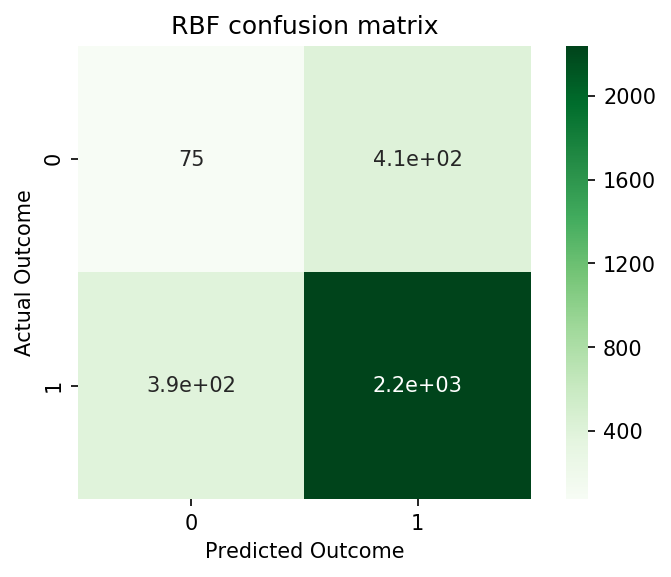

In [17]:
rbf_confusion = confusion_matrix(y, y_predict_hard_full)
plt.figure(dpi=150)
sns.heatmap(rbf_confusion, cmap=plt.cm.Greens, annot=True, square=True)

plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.title('RBF confusion matrix');

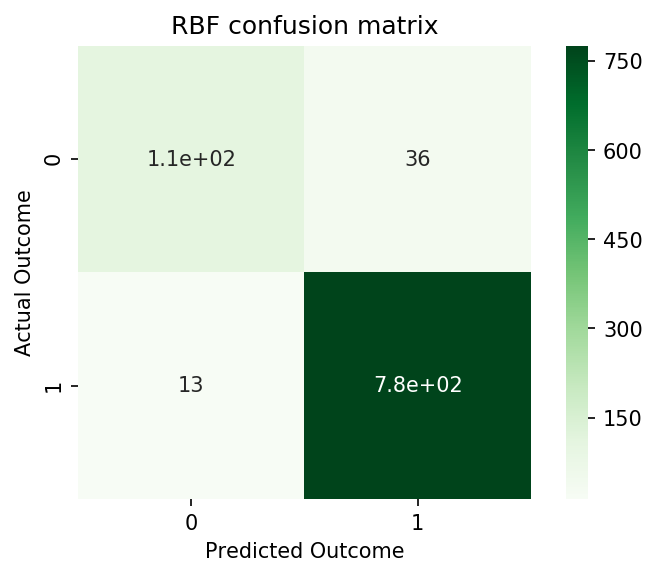

In [18]:
rbf_confusion = confusion_matrix(y_test, y_predict_hard)
plt.figure(dpi=150)
sns.heatmap(rbf_confusion, cmap=plt.cm.Greens, annot=True, square=True)

plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.title('RBF confusion matrix');

In [19]:
order_of_train_set = X_train.index
train_fips = df.loc[order_of_train_set, 'fips'].values

In [20]:
order_of_test_set = X_test.index
test_fips = df.loc[order_of_test_set, 'fips'].values

In [21]:
predict_fips = np.concatenate((test_fips, train_fips), axis=0)

In [22]:
county_likelihood = np.concatenate((predict_fips.reshape(-1,1), y_predict.reshape(-1,1)), axis=1)

In [23]:
df2 = pd.DataFrame(county_likelihood, columns=['fips','probability'])

In [24]:
fips = df2['fips'].tolist()
values=df2['probability'].tolist()
colorscale = ["#CB4335","#E74C3C","#EC7063","#F1948A","#F5B7B1","#FADBD8","#FDEDEC",
              "#EBF5FB","#D6EAF8","#AED6F1","#85C1E9","#5DADE2","#3498DB","#2E86C1"]
endpts = list(np.linspace(0, 1, len(colorscale) - 1))

In [25]:
fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    show_state_data=False,
    show_hover=True, centroid_marker={'opacity': 0},
    colorscale = colorscale,
    asp=2.9, title='Vote by Party',
    legend_title='Likelihood to vote for Democrat'
)
py.iplot(fig, filename='vote_by_party_likelihood')

The draw time for this plot will be slow for clients without much RAM.


/anaconda3/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow



## Make a histogram with Probability

In [26]:
df3 = pd.merge(df2,df[['result_2016','fips']],how='inner', on=['fips'])

In [27]:
df3.head(5)

,fips,probability,result_2016
0,26095,0.959814,1
1,48475,0.970035,1
2,37161,0.996046,1
3,48077,1,1
4,37183,0.0384981,0


In [28]:
x0 = df2[df3.result_2016==0].values[:,1]
x1 = df2[df3.result_2016==1].values[:,1]

trace1 = go.Histogram(
    x=x0,
    name = 'Voted Republican',
    marker = dict(
        color='#CB4335'
    ),
    opacity=1,
)
trace2 = go.Histogram(
    x=x1,
    name='Voted Democrat',
    marker = dict(
        color = '#3498DB'
    ),
    opacity=0.5,
)
    
data = [trace1, trace2]
layout = go.Layout(
        barmode='overlay', 
        title="Predicted vs. Outcome", 
        xaxis = dict(
            title='Likelihood of voting for Democrat'
        ),
        yaxis = dict(
            title = 'Number of Actual Votes by Party'
        )
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Predicted vs. Outcome')

In [29]:
x = df2.probability
data = [go.Histogram(x=x)]

py.iplot(data, filename='initial histogram')

## Plotting the probability that the prediction is wrong

In [30]:
df3.head(5)

,fips,probability,result_2016
0,26095,0.959814,1
1,48475,0.970035,1
2,37161,0.996046,1
3,48077,1,1
4,37183,0.0384981,0


In [31]:
df3['diff']=df3.probability - df3.result_2016

In [32]:
df3.head(5)

,fips,probability,result_2016,diff
0,26095,0.959814,1,-0.0401861
1,48475,0.970035,1,-0.0299646
2,37161,0.996046,1,-0.00395416
3,48077,1,1,-2.2904e-07
4,37183,0.0384981,0,0.0384981


In [33]:
df3['predicted']= np.where(df3['probability']>=0.5, 1, 0)

In [34]:
df3.drop(columns=['diff'], inplace=True)

In [35]:
df3['diff'] = df3['probability'] - df3['result_2016']
df3_different = df3[df3.result_2016!=df3.predicted]

In [36]:
df3_different.sort_values('diff',ascending=False)

,fips,probability,result_2016,predicted,diff
574,06037,1,0,1,1
3062,55049,0.990801,0,1,0.990801
1353,55045,0.983078,0,1,0.983078
903,41041,0.974691,0,1,0.974691
278,26121,0.965902,0,1,0.965902
1154,06033,0.964559,0,1,0.964559
247,23027,0.958315,0,1,0.958315
825,55003,0.957688,0,1,0.957688
2008,39099,0.956928,0,1,0.956928
2099,51131,0.952187,0,1,0.952187


In [37]:
fips = df3['fips'].tolist()
values=df3['diff'].tolist()
blank = '#ACACAC'
colorscale = ["#CB4335","#E74C3C","#EC7063", blank, blank, blank, blank,
              blank,blank,blank,blank,"#5DADE2","#3498DB","#2E86C1"]
endpts = list(np.linspace(-1, 1, len(colorscale) - 1))

In [38]:
fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    show_state_data=False,
    show_hover=True, centroid_marker={'opacity': 0},
    colorscale = colorscale,
    asp=2.9, title='Inaccurate Prediction',
    legend_title='Likelihood of wrong prediction'
)
py.iplot(fig, filename='Likelihood of wrong prediction')

The draw time for this plot will be slow for clients without much RAM.


/anaconda3/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow



## Monte Carlo Simulation

In [39]:
stddiv = df.iloc[:,1:-2].std().values.reshape(1,-1)

In [40]:
stddiv.shape

(1, 43)

In [41]:
%%time
num_simulations, num_counties = 1000, df.shape[0]
prediction_outcomes = np.zeros((num_simulations, num_counties))

for sim_number in range(num_simulations):
    noise = np.random.normal(size=(df.shape[0], stddiv.shape[1]))
    
    X_new = X.values +  stddiv*noise
    X_new_scaled = ssX.transform(X_new)
    y_predict = rbf1.predict(X_new_scaled)
    
    prediction_outcomes[sim_number,:] = y_predict

CPU times: user 57.7 s, sys: 468 ms, total: 58.1 s
Wall time: 58.6 s


In [42]:
prediction_outcomes.shape

(1000, 3111)

In [43]:
df['mean'] = prediction_outcomes.mean(axis=0).reshape(-1,1)

In [44]:
df.head()

,county,less_than_high_school_diploma,at_least_high_school_diploma,at_least_bachelorss_degree,graduate_degree,school_enrollment,median_earnings_2010,white_not_latino_population,african_american_population,native_american_population,...,hiv_prevalence_rate,uninsured,unemployment,violent_crime,homicide_rate,injury_deaths,infant_mortality,result_2016,fips,mean
0,"Lonoke County, Arkansas",14.2,85.8,16.6,4.9,75.45,28134.093970,88.0,6.35,0.50,...,57.3,0.165,0.061,390.71,4.240000,71.1,6.800,1,05085,0.952
1,"Monroe County, Arkansas",31.4,68.6,12.3,3.7,80.25,20974.931745,56.8,39.90,0.50,...,345.1,0.200,0.084,202.77,9.861842,112.9,8.820,1,05095,0.746
2,"Drew County, Arkansas",19.4,80.6,19.4,5.7,78.50,21988.947300,67.9,27.95,0.15,...,79.9,0.197,0.108,449.02,9.861842,82.0,8.820,1,05043,0.803
3,"Madison County, Arkansas",24.2,75.8,13.4,4.1,76.40,23365.948890,92.0,0.25,1.25,...,131.3,0.239,0.053,245.83,9.861842,96.8,8.820,1,05087,0.973
4,"Jasper County, Georgia",21.7,78.3,13.3,5.6,70.20,25363.060950,72.7,22.20,0.40,...,402.4,0.239,0.096,205.60,6.990811,71.6,9.172,1,13159,0.916


In [45]:
fips = df['fips'].tolist()
values=df['mean'].tolist()
colorscale = ["#CB4335","#E74C3C","#EC7063","#F1948A","#F5B7B1","#FADBD8","#FDEDEC",
              "#EBF5FB","#D6EAF8","#AED6F1","#85C1E9","#5DADE2","#3498DB","#2E86C1"]
endpts = list(np.linspace(0, 1, len(colorscale) - 1))

In [46]:
fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    show_state_data=False,
    show_hover=True, centroid_marker={'opacity': 0},
    colorscale = colorscale,
    asp=2.9, title='Vote by Party - Monte Carlo Simulation',
    legend_title='Likelihood to vote for Democrat'
)
py.iplot(fig, filename='vote_by_party_likelihood_simulation')

The draw time for this plot will be slow for clients without much RAM.


/anaconda3/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow

